In [ ]:
cd ..

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
# from ggm_estimation.utils import _lambda_generic, lambda_glasso_selector
from ggm_estimation.format_results import plot_glasso_tuning

np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 2

#### Tuning

In [3]:
# graph_type = "deezer"
# nans = 0.05
# one_zero_ratio = 0.5
# n_proportional = True
# metric = "accuracy"

# graph_type = "barabasi"
# nans = 30
# one_zero_ratio = 0.5
# n_proportional = False
# metric = "accuracy"

graph_type = "deezer"
nans = 0.5
one_zero_ratio = None
n_proportional = True
metric = "f1"

# graph_type = "grids"
# graph_type = "barabasi"
# nans = 0.1
# one_zero_ratio = 0.2
# n_proportional = True
# metric = "f1"

# graph_type = "grids"
# nans = 0.2
# one_zero_ratio = None
# n_proportional = True
# metric = "f1"

filename = f"outputs/tuning/tuning_glasso_{graph_type}_{nans}_{n_proportional}_{one_zero_ratio}_{metric}.csv"

[ 2.10615704 -5.49361124 18.04472622]


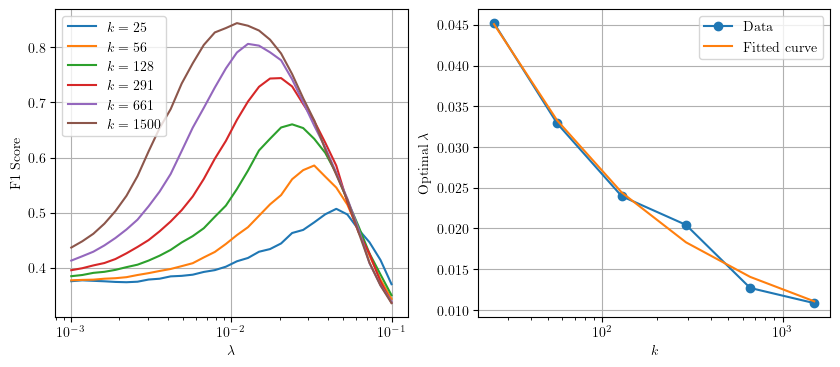

In [11]:
# plot_glasso_tuning(filename, graph_type, nans, n_proportional, one_zero_ratio)
plot_glasso_tuning(filename, metric="F1 Score", output_file=f"outputs/plots/tuning_glasso_{graph_type}.pdf")